In [2]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## Tool limitiation We can go as fine as 1degC, 1 mm/s, 10 uL/min, and 1% duty cycle

## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [140, 150, 1] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [125, 175, 1] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [3000, 3500, 10] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [16, 20, 1] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 50, 1] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [1.0, 1.2, 0.05] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temperature [\N{DEGREE SIGN}C]', 
            'Speed [mm/s]',
            'Spray Flow [uL/min]', 
            'Plamsa Height [cm]', 
            'Plasma Gas Flow [L/min]', 
            'Plasma DC [%]']
def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('temp', 0-1/(temp_num-1)/2, 1+1/(temp_num-1)/2),
                                 ContinuousParameter('speed', 0-1/(speed_num-1)/2, 1+1/(speed_num-1)/2),
                                 ContinuousParameter('sprayFL', 0-1/(sprayFL_num-1)/2, 1+1/(sprayFL_num-1)/2),
                                 ContinuousParameter('plamsaH', 0-1/(plasmaH_num-1)/2, 1+1/(plasmaH_num-1)/2),
                                 ContinuousParameter('gasFL', 0-1/(gasFL_num-1)/2, 1+1/(gasFL_num-1)/2),
                                 ContinuousParameter('plasmaDC', 0-1/(plasmaDC_num-1)/2, 1+1/(plasmaDC_num-1)/2)
                                 ])


In [5]:
df_LHS = pd.DataFrame(data=get_closest_array(x_denormalizer(LatinDesign(parameter_space).get_samples(14))), columns = x_labels)
df_LHS

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%]
0,145.0,155.0,3160.0,1.00,16.0,25.0
1,142.0,174.0,3090.0,1.15,19.0,29.0
2,148.0,148.0,3200.0,1.00,17.0,42.0
3,145.0,145.0,3010.0,1.05,17.0,40.0
4,140.0,137.0,3050.0,1.05,19.0,48.0
5,149.0,134.0,3300.0,1.15,18.0,46.0
6,143.0,159.0,3490.0,1.20,17.0,35.0
7,147.0,166.0,3380.0,1.20,16.0,37.0
8,146.0,141.0,3230.0,1.00,20.0,38.0
9,141.0,170.0,3270.0,1.20,16.0,31.0


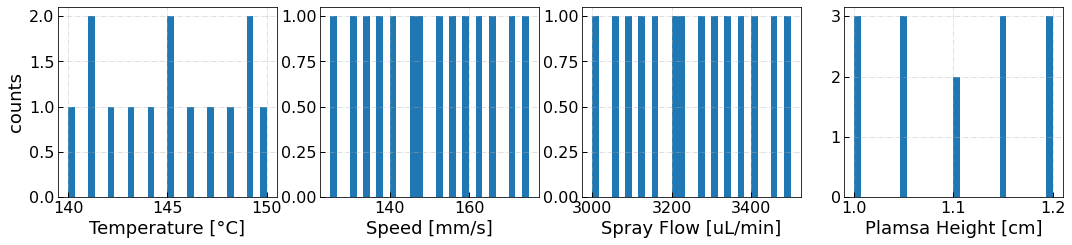

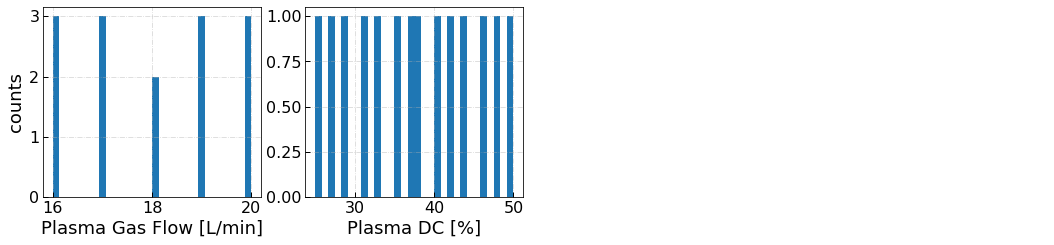

In [6]:
df = df_LHS
df_cols = x_labels
n_col = 4 # num of columns per row in the figure

for n in np.arange(0, 8, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df.iloc[:,n], bins= 30, range = (min(var_array[n]),max(var_array[n])))####
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
            #axes[i].set_xlim(min(var_array[n])*0.8,max(var_array[n])*1.05)
        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

In [7]:
model_top = get_closest_array(np.array([[147.21, 151.26, 3278.52, 1.15, 17.22, 39.18]]))
model_top

array([[1.47e+02, 1.51e+02, 3.28e+03, 1.15e+00, 1.70e+01, 3.90e+01]])

In [8]:
exp_top5 = np.array([
    [140,150,3500,1.2,20,50], #17.13% #67
    [135,150,4000,0.8,20,50], #17.37% #44
    [145,125,3000,1.2,16,50], #17.43% #72
    [150,175,3500,1.0,16,50], #17.66% #78
    [145,125,3500,1.0,25,50]  #17.70% #72
])

In [9]:
df_opt = pd.DataFrame(data=get_closest_array(np.concatenate([model_top, exp_top5])), columns = x_labels)
df_opt

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%]
0,147.0,151.0,3280.0,1.15,17.0,39.0
1,140.0,150.0,3500.0,1.20,20.0,50.0
2,140.0,150.0,3500.0,1.00,20.0,50.0
3,145.0,125.0,3000.0,1.20,16.0,50.0
4,150.0,175.0,3500.0,1.00,16.0,50.0
5,145.0,125.0,3500.0,1.00,20.0,50.0


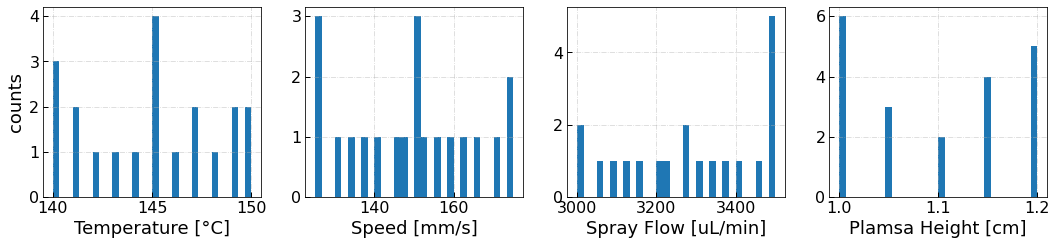

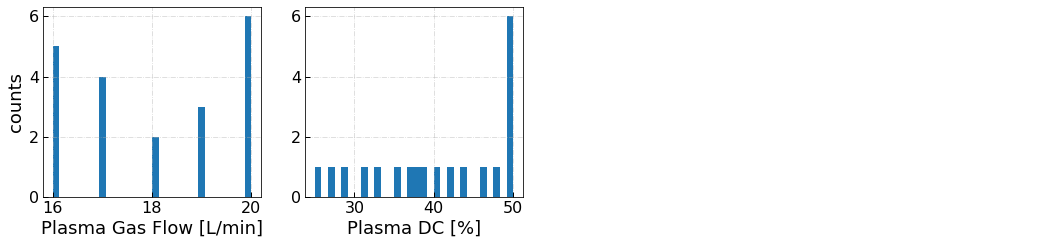

In [10]:
df =  pd.concat([df_LHS, df_opt])
df_cols = x_labels
n_col = 4 # num of columns per row in the figure

for n in np.arange(0, 8, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df.iloc[:,n], bins= 30, range = (min(var_array[n]),max(var_array[n])))####
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
            #axes[i].set_xlim(min(var_array[n])*0.8,max(var_array[n])*1.05)
        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

In [11]:
from typing import Union
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization import AcquisitionOptimizerBase
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition
from emukit.bayesian_optimization.local_penalization_calculator import LocalPenalizationPointCalculator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      MultipointExpectedImprovement,\
                                                      ProbabilityOfFeasibility
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

class ProbabilisticConstraintBayesianOptimizationLoop2(OuterLoop):
    def __init__(self, space: ParameterSpace, model_objective: Union[IModel, IDifferentiable],
                 model_constraint1: Union[IModel, IDifferentiable], 
                 model_constraint2: Union[IModel, IDifferentiable],
                 acquisition: Acquisition = None,
                 update_interval: int = 1, batch_size: int = 1):

        """
        Emukit class that implements a loop for building Bayesian optimization with an unknown constraint.
        For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param space: Input space where the optimization is carried out.
        :param model_objective: The model that approximates the underlying objective function
        :param model_constraint: The model that approximates the unknown constraints
        :param acquisition: The acquisition function for the objective function (default, EI).
        :param update_interval:  Number of iterations between optimization of model hyper-parameters. Defaults to 1.
        :param batch_size: How many points to evaluate in one iteration of the optimization loop. Defaults to 1.
        """

#         if not np.all(np.isclose(model_objective.X, model_constraint.X)):
#             raise ValueError('Emukit currently only supports identical '
#                              'training inputs for the constrained and objective model')
        self.model_objective = model_objective
        self.model_constraint1 = model_constraint1
        self.model_constraint2 = model_constraint2
        
        if acquisition is None:
            acquisition = ExpectedImprovement(model_objective)
        
        acquisition_constraint1 = ScaledProbabilityOfFeasibility(model_constraint1, max_value = 1, min_value = 0.5)
        acquisition_constraint2 = ScaledProbabilityOfFeasibility(model_constraint2, max_value = 1, min_value = 0.8)
        acquisition_constraint = acquisition_constraint1*acquisition_constraint2
        acquisition_constrained = acquisition * acquisition_constraint

        model_updater_objective = FixedIntervalUpdater(model_objective, update_interval)
        model_updater_constraint1 = FixedIntervalUpdater(model_constraint1, update_interval,
                                                        lambda state: state.Y_constraint1)
        model_updater_constraint2 = FixedIntervalUpdater(model_constraint2, update_interval,
                                                        lambda state: state.Y_constraint2)

        acquisition_optimizer = GradientAcquisitionOptimizer(space)
        if batch_size == 1:
            candidate_point_calculator = SequentialPointCalculator(acquisition_constrained, acquisition_optimizer)
        else:
            log_acquisition = LogAcquisition(acquisition_constrained)
            candidate_point_calculator = LocalPenalizationPointCalculator(log_acquisition, acquisition_optimizer,
                                                                          model_objective, space, batch_size)
        loop_state = create_loop_state(model_objective.X, model_objective.Y)
        
        #loop_state = create_loop_state(model_objective.X, model_objective.Y, Y_constraint=model_constraint.Y)

        super(ProbabilisticConstraintBayesianOptimizationLoop2, self).__init__(candidate_point_calculator,
                                                                              [model_updater_objective, model_updater_constraint1,model_updater_constraint2],
                                                                              loop_state)
#     def suggest_next_locations(self):
#         return self.candidate_point_calculator.compute_next_points(self.loop_state)
    
#     def acquisition_evaluate(self, X: loop_sate.X):
#         return acquisition.evaluate(X), acquisition_constraint.evaluate(X), acquisition_constrained.evaluate(X)


In [12]:
from typing import Tuple, Union
import scipy.stats
import numpy as np
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel, IDifferentiable

class ScaledProbabilityOfFeasibility(Acquisition):

    def __init__(self, model: Union[IModel, IDifferentiable], jitter: float = float(0),
                 max_value: float = float(1), min_value: float = float(0)) -> None:
        """
        This acquisition computes for a given input point the probability of satisfying the constraint
        C<0. For more information see:
        Michael A. Gelbart, Jasper Snoek, and Ryan P. Adams,
        Bayesian Optimization with Unknown Constraints,
        https://arxiv.org/pdf/1403.5607.pdf
        :param model: The underlying model that provides the predictive mean and variance for the given test points
        :param jitter: Jitter to balance exploration / exploitation
        """
        self.model = model
        self.jitter = jitter
        self.max_value = max_value
        self.min_value = min_value

    def evaluate(self, x: np.ndarray) -> np.ndarray:
        """
        Computes the probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: numpy array with the probability of satisfying the constraint at the points x.
        """
        mean, variance = self.model.predict(x)
        mean += self.jitter

        standard_deviation = np.sqrt(variance)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        return cdf*(self.max_value-self.min_value)+self.min_value

    def evaluate_with_gradients(self, x: np.ndarray) -> Tuple:
        """
        Computes the  probability of of satisfying the constraint C<0.
        :param x: points where the acquisition is evaluated, shape (number of points, number of dimensions).
        :return: tuple of numpy arrays with the probability of satisfying the constraint at the points x 
        and its gradient.
        """
        mean, variance = self.model.predict(x)
        standard_deviation = np.sqrt(variance)

        dmean_dx, dvariance_dx = self.model.get_prediction_gradients(x)
        dstandard_devidation_dx = dvariance_dx / (2 * standard_deviation)

        mean += self.jitter
        u = - mean / standard_deviation
        pdf = scipy.stats.norm.pdf(0, mean, standard_deviation)
        cdf = scipy.stats.norm.cdf(0, mean, standard_deviation)
        dcdf_dx = - pdf * (dmean_dx + dstandard_devidation_dx * u)

        return cdf*(self.max_value-self.min_value)+self.min_value, dcdf_dx

    @property
    def has_gradients(self):
        return isinstance(self.model, IDifferentiable)

In [13]:
#np.random.seed(10)

from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

x_init = x_normalizer(df_device.iloc[:,2:8].values)
y_init = np.transpose([df_device.iloc[:,-1].values])
xc_init = x_normalizer(df_film.iloc[:,1:-2].values)
yc_init = np.transpose([df_film.iloc[:,-2].values])
X, Y, Xc, Yc = [x_init, y_init, xc_init, yc_init]

Xc2 = x_normalizer(df_previous.iloc[:,0:6].values)
Yc2 = np.transpose([df_previous.iloc[:,-1].values])

input_dim = len(X[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
ker.lengthscale.constrain_bounded(1e-1, 1)
ker.variance.constrain_bounded(1e-1, 1000.0)
# ker += GPy.kern.White(input_dim = input_dim)
# ker += GPy.kern.Bias(input_dim = input_dim)
model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
# model_gpy.Gaussian_noise.variance = 2.01**2
# model_gpy.Gaussian_noise.variance.fix()
model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model = GPyModelWrapper(model_gpy)

input_dim = len(Xc[0])
ker = GPy.kern.RBF(input_dim = input_dim, ARD = True)
ker.lengthscale.constrain_bounded(1e-1, 1)#upper bound set to 1 
ker.variance.constrain_bounded(1e-1, 1000.0) 
#ker += GPy.kern.White(input_dim = input_dim)
yc_offset = 0.5 # constraint acquisition computes the probability of <0
gpy_constraint_model = GPRegression(Xc, -(Yc-yc_offset), ker) #Emukit is a minimization tool; need to make Y negative;
gpy_constraint_model.Gaussian_noise.variance = 0.1**2
gpy_constraint_model.Gaussian_noise.variance.fix()
gpy_constraint_model.randomize()
gpy_constraint_model.optimize_restarts(num_restarts=20,verbose =False, messages=False) 
constraint_model1 = GPyModelWrapper(gpy_constraint_model)

input_dim = len(Xc2[0])
ker = GPy.kern.RBF(input_dim = input_dim, ARD =True)#
ker.lengthscale.constrain_bounded(0.5, 1)#avoid overfitting; use a large lower bound
ker.variance.constrain_bounded(1e-1, 1000.0)
#ker += GPy.kern.White(input_dim = input_dim)
yc2_offset = np.mean(Yc2)  # constraint acquisition computes the probability of <0
gpy_constraint_model2 = GPRegression(Xc2 , -(Yc2-yc2_offset), ker) #Emukit is a minimization tool; need to make Y negative;
gpy_constraint_model2.randomize()
gpy_constraint_model2.optimize_restarts(num_restarts=20,verbose =False, messages=False)
constraint_model2 = GPyModelWrapper(gpy_constraint_model2)


NameError: name 'df_device' is not defined

In [ ]:
f_obj =  objective_model.model.predict
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

yc_pred, yc_uncer = f_cons1(Xc)
yc_pred = -yc_pred[:,-1]+yc_offset
yc_uncer = np.sqrt(yc_uncer[:,-1])

yc2_pred, yc2_uncer = f_cons2(Xc2)
yc2_pred = -yc2_pred[:,-1]+yc2_offset
yc2_uncer = np.sqrt(yc2_uncer[:,-1])


from sklearn.metrics import mean_squared_error
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 18
lims1 = (0, 20)
axes[0].scatter(Y[:,-1], y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(Y[:,-1], y_pred, yerr = y_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
title = 'GPR for Obj Fcn' + " (RMSE=%.2f" % rmse_value+' [%])'
axes[0].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[0].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[0].set_title(title, fontsize = fs)

lims2 = (-.1, 1.1)
axes[1].scatter(Yc[:,-1], yc_pred, alpha = 0.6, edgecolor = 'r', c = 'r')
axes[1].errorbar(Yc[:,-1], yc_pred, yerr = yc_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)

axes[1].plot(lims2, lims2, 'k--', alpha=0.75, zorder=0)
title = 'GPR for Binary Film Quality'
axes[1].set_xlabel('Ground Truth Film Quality [%]', fontsize = fs)
axes[1].set_ylabel('Prediction Film Quality [%]', fontsize = fs)
axes[1].set_title(title, fontsize = fs)


lims3 = (0, 17)
axes[2].scatter(Yc2[:,-1], yc2_pred, alpha = 0.5, c = 'darkorange', edgecolor = 'darkorange')
axes[2].errorbar(Yc2[:,-1], yc2_pred, yerr = yc2_uncer, ms = 0, 
             ls = '', capsize = 2, alpha = 0.6,
             color = 'gray', zorder = 0)
axes[2].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Yc2[:,-1], yc2_pred))
title = 'GPR for Prev Data' + " (RMSE=%.2f" % rmse_value+' [%])'

axes[2].set_xlabel('Ground Truth Efficiency [%]', fontsize = fs)
axes[2].set_ylabel('Prediction Efficiency [%]', fontsize = fs)
axes[2].set_title(title, fontsize = fs)

        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

In [ ]:
## Expeceted Improvement (EI)
## acquisition = ExpectedImprovement(objective_model, jitter=.0)
## Lower Confidence Bound (LCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)
## Maximum Value Entropy Search (MES)
#acquisition = MaxValueEntropySearch(objective_model, parameter_space, grid_size = 10000*6)

## fully integreated acquisition
# #acquisition_generator = lambda m: ExpectedImprovement(m, jitter=.1)
# acquisition_generator = lambda m: NegativeLowerConfidenceBound(m, beta = 1)
# acquisition_integrated = IntegratedHyperParameterAcquisition(objective_model, acquisition_generator)
# acquisition = acquisition_integrated

# Make loop and collect points
bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size = 22)#batchsize>20 to account for duplication

X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(bayesopt_cons_pr.loop_state)

f_obj =  objective_model.model.predict       
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

f_cons_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
f_raw_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate

print('total condition no.:', len(Xc))
print('total device no.:', len(bayesopt_cons_pr.loop_state.Y))
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt_cons_pr.loop_state.Y, 2))))

X_new = x_normalizer(get_closest_array(x_denormalizer(X_new)))
df_Xnew = pd.DataFrame(get_closest_array(x_denormalizer(X_new)), columns = df_film.columns[1:7])
df_all = pd.concat([df_film.iloc[:,1:7], df_Xnew])#.sort_values(by=list(df_film.columns[1:7]))
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[len(df_film):len(df_film)+20]
df_Xnew = df_Xnew.sort_values(by=list(df_film.columns[1:7]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df_film)
df_Xnew